In [1]:
import os
from itertools import product
from collections import Counter

# Data
import numpy as np
import pandas as pd

# Plots
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
plt.rc('axes', edgecolor='#0066bf')

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

# Image processing
import cv2
from imutils import contours

## Load data

In [2]:
img_test = np.load('../data/test-dataset.npy')

In [3]:
def load_model(model_name):
    with open (f'../models/{model_name}.json') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json)
    model.load_weights(f'../models/{model_name}.h5')
    print(f'Loaded model {model_name}.')
    return model

model = load_model('cnn')

Loaded model cnn.


## Image Prediction

### Raw image

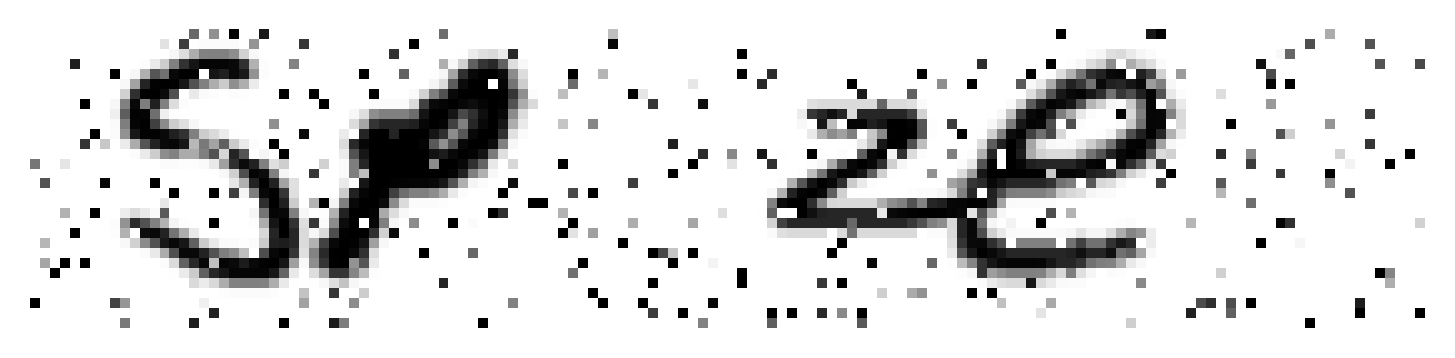

In [4]:
image = img_test[1798]

fig, ax = plt.subplots(figsize=(6,2), dpi=300)
ax.imshow(image, cmap='binary')
ax.axis('off')
plt.savefig('../figures/denoise_example_original.png', dpi=300, bbox_inches='tight')
plt.show()

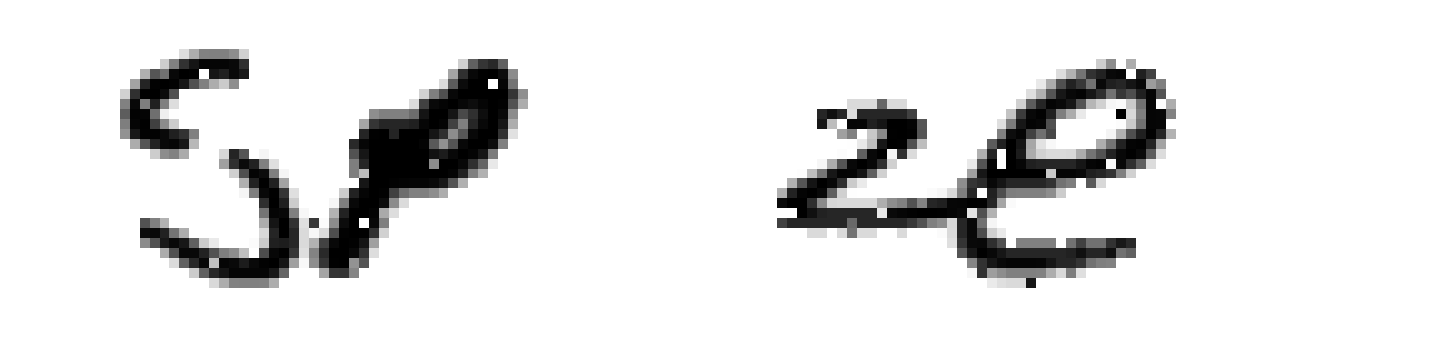

In [5]:
def _denoise_image(raw_image):
    '''Returns the the denoised image'''
    denoised_image = raw_image.copy()
    denoised_image = cv2.convertScaleAbs(denoised_image)
    mask = np.zeros(denoised_image.shape, dtype=np.uint8)
    blur = cv2.GaussianBlur(denoised_image, (7, 7), 0)
    _, thresh = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    denoised_image[thresh == 0] = 0
    return denoised_image


denoised_image = _denoise_image(image.copy())

fig, ax = plt.subplots(figsize=(6,2), dpi=300)
ax.imshow(denoised_image, cmap='binary')
ax.axis('off')
plt.savefig('../figures/denoise_example_denoised.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
def _find_contours(denoised_image, min_area=25):
    '''Returns a contours object with the contrours'''
    cnts = cv2.findContours(denoised_image,
                            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = [c for c in cnts if min_area < cv2.contourArea(c)]
    if len(cnts) > 4:
        cnts = sorted(cnts, key=cv2.contourArea)[-4:]
    cnts, _ = contours.sort_contours(cnts, method='left-to-right')
    return cnts

cnts = _find_contours(denoised_image.copy())
print(f'Found {len(cnts)} potential letters')

Found 3 potential letters


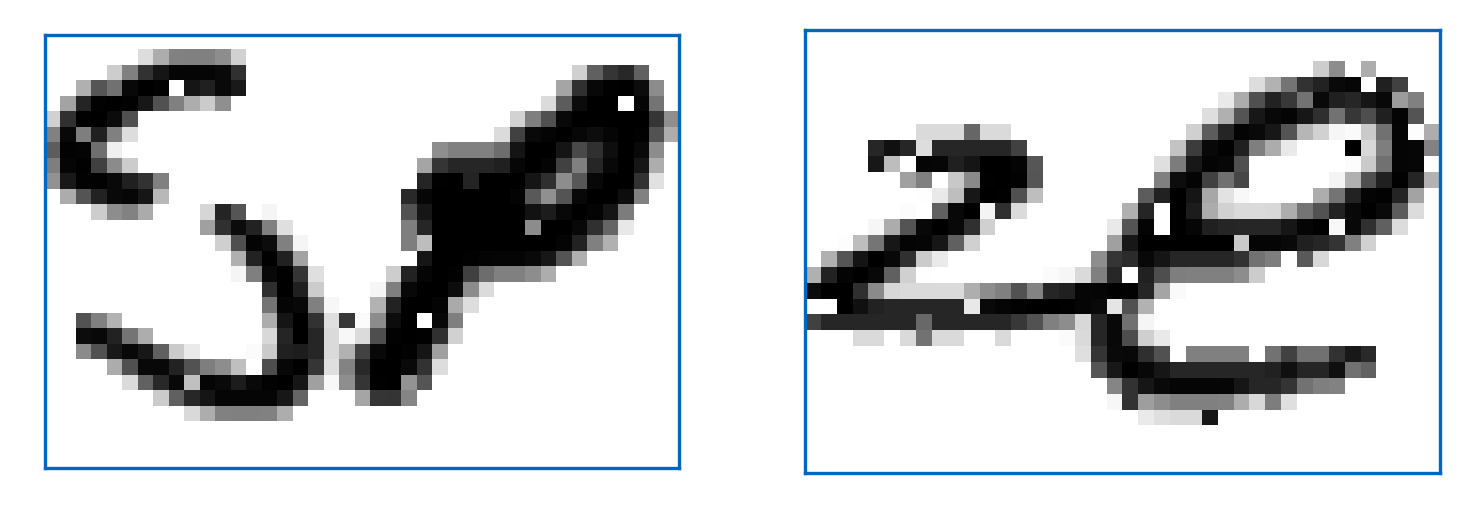

In [7]:
def _contours_to_images(cnts, denoised_image):
    '''Converts the letter contours to images'''
    contour_images = []
    x_prev = 0
    for c in cnts:
        x, _, w, _ = cv2.boundingRect(c)
        x_start, x_end = x, x+w
        image = denoised_image[1:29, x_start:x_end]
        if x_prev == 0 or x_start > x_prev:
            contour_images.append(image)
        else:
            prev_image = contour_images[-1]
            contour_images[-1] = np.hstack([prev_image,
                                            denoised_image[1:29, x_prev:x_end]])
        x_prev = x_end
    return contour_images

cnts_images = _contours_to_images(cnts, denoised_image)

fig, axes = plt.subplots(ncols=len(cnts_images), figsize=(6,2), dpi=300)
for i, img in enumerate(cnts_images):   
    axes[i].imshow(img, cmap='binary')
    axes[i].grid(False)
plt.setp(axes, xticks=[], yticks=[])
plt.savefig('../figures/denoise_example_seperated.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def _reshape_image(image):
    '''Returns padded image with shape 28x28'''
    width = image.shape[1]
    if width >= 28:
        return image[:, 0:28]
    else:
        pad = 28 - width
        pad_left = np.ceil(pad/2).astype('int')
        pad_right = np.floor(pad/2).astype('int')
        return np.pad(image, ((0, 0), (pad_left, pad_right)))

In [9]:
def _split_image(image, n):
    '''
    Split image evenly in n images. Attemps to split the image at a gap
    between the letters. Othewise splits image naively in equal parts.
    '''
    split_point = np.argmin(image.sum(axis=0))
    if (n==2 and image[:, split_point].sum() < 250 and
            0.2 < (split_point/image.shape[1]) < 0.8):
        return image[:, :split_point], image[:, split_point:]
    else:
        return np.array_split(image, n, axis=1)

In [10]:
def _split_images(images):
    '''Splits the wide images in multiple images to return 4 images'''
    num_images = len(images)

    image_width = [i.shape[1] for i in images]
    images_to_split = len([w for w in image_width if w > 28])
    if images_to_split == 0:
        images_to_split = 1

    splits = (4-num_images) / images_to_split
    for _ in range(images_to_split):
        image_width = [i.shape[1] for i in images]
        large_image_index = np.argsort(image_width)[-1]
        image = images[large_image_index]
        images[large_image_index:large_image_index +
                1] = _split_image(image, splits+1)
    return images

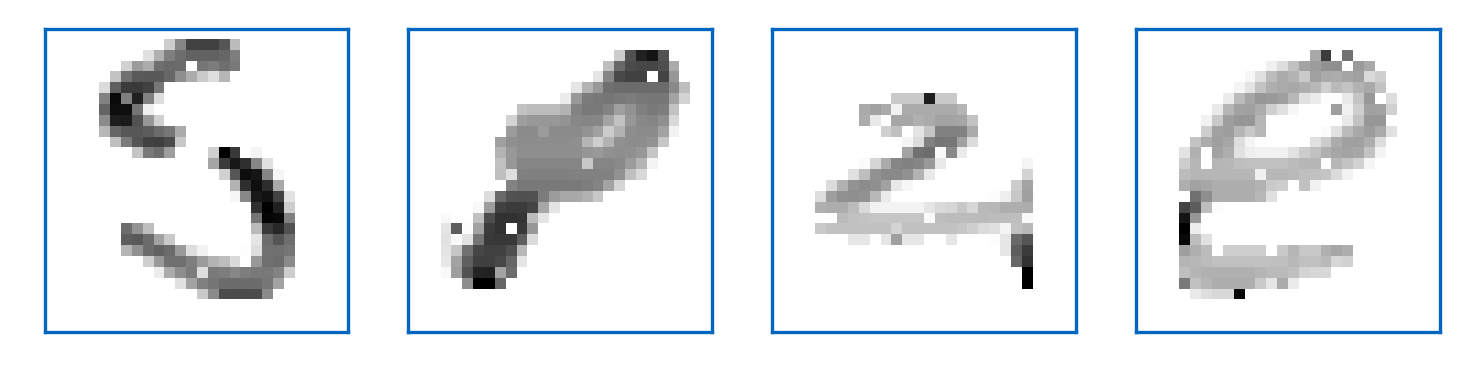

In [11]:
def _clean_images(cnts_images):
    '''Returns 4 images of shape 28x28.'''
    images = cnts_images.copy()
    if len(images) < 4:
        images = _split_images(images)

    letter_images = []
    for image in images:
        image = _reshape_image(image)
        image = tf.keras.utils.normalize(image, axis=1)
        letter_images.append(image)
    return letter_images

letter_images = _clean_images(cnts_images)
fig, axes = plt.subplots(ncols=len(letter_images), figsize=(6,2), dpi=300)
for i, img in enumerate(letter_images):   
    axes[i].imshow(img, cmap='binary')
    axes[i].grid(False)
plt.setp(axes, xticks=[], yticks=[])
plt.savefig('../figures/denoise_example_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def get_letter_probabilities(letter_images):
    '''
    Returns dictionary with the 5 most probable letters predicted by the
    model for the four images.
    '''
    letter_probabilities = []
    for i, image in enumerate(letter_images):
        probabilities = model.predict(image.reshape(1, 28, 28, 1))[0]
        sorted_probabilities = np.sort(probabilities)[::-1]
        sorted_index = np.argsort(probabilities)[::-1]
        predictions = {k+1: v for k,
                        v in zip(sorted_index, sorted_probabilities)}
        letter_probabilities.append(
            dict(Counter(predictions).most_common(5)))
    return letter_probabilities

letter_probabilities = get_letter_probabilities(letter_images)
print(letter_probabilities)

[{19: 1.0, 10: 2.8657751e-12, 7: 2.9222233e-17, 5: 4.109897e-24, 6: 3.6411093e-25}, {16: 0.99995136, 7: 2.6929034e-05, 17: 1.44884125e-05, 5: 7.12383e-06, 1: 1.7301968e-09}, {26: 1.0, 18: 3.5596293e-09, 7: 9.94551e-11, 17: 4.5111057e-11, 1: 2.1689173e-13}, {5: 0.9999974, 18: 2.5935403e-06, 3: 2.4586154e-15, 16: 1.0971306e-15, 1: 4.93658e-16}]


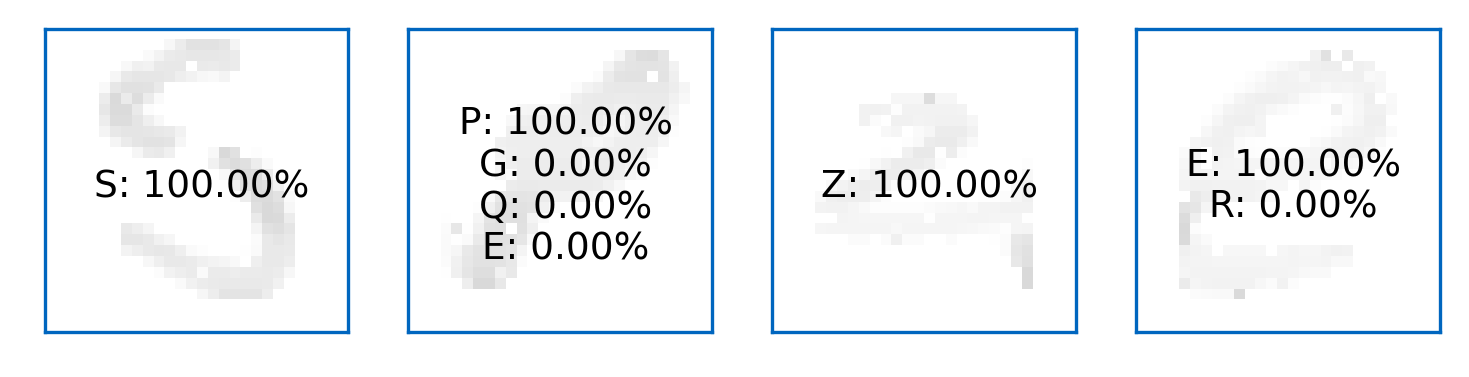

In [13]:
letter_images = _clean_images(cnts_images)
fig, axes = plt.subplots(ncols=len(letter_images), figsize=(6,2), dpi=300)
for i, (img, lp) in enumerate(zip(letter_images, letter_probabilities)):
    title = ''
    for k, v in lp.items():
        if v > 0.000001:
            title += f'{chr(k+64)}: {v:.2%}\n'
    axes[i].imshow(img, cmap='binary', alpha=0.15)
    axes[i].grid(False)
    axes[i].text(14, 14, title.strip(), fontsize=9, horizontalalignment='center', verticalalignment='center')
plt.setp(axes, xticks=[], yticks=[])
plt.savefig('../figures/denoise_example_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
def get_5_predictions(letter_probabilities):
    '''
    Returns the 5 most probable four letter combinations predicted by the
    model'''
    combinations = list(product(*[d.values()
                                    for d in letter_probabilities]))
    letter_index = list(product(*letter_probabilities))

    top_5_predictions = []
    for i in range(5):
        probs = np.argsort(np.prod(combinations, axis=1))[::-1][i]
        letters = letter_index[probs]
        pred = ''.join(str(l).zfill(2) for l in letters)
        top_5_predictions.append(pred)
    return top_5_predictions

top_predictions = get_5_predictions(letter_probabilities)
print(top_predictions)

['19162605', '19072605', '19172605', '19052605', '19162618']


In [15]:
def convert_to_letters(top_predictions):
    '''Returns a string of four letters that corresponds to the predicted label'''
    letters = []
    for l in top_predictions:
        ints = [int(l[i:i+2]) for i in range(0, len(l), 2)]
        lbls = [chr(i+64) for i in ints]
        letters.append(''.join(lbls))
    return letters
    
for i, p in enumerate(convert_to_letters(top_predictions), start=1):
    print(f'({i}) {p}')

(1) SPZE
(2) SGZE
(3) SQZE
(4) SEZE
(5) SPZR
